# Evaluation Face Matching Model

Preparation of the LFW (Labeled Faces in the Wild) dataset for training and evaluating face matching models.

## Environment Setup

In [ ]:
# Install required packages
!pip install kagglehub pandas scikit-learn numpy

In [14]:
# Import libraries
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Preparation

In [15]:
# Download LFW dataset from Kaggle
print("Downloading LFW dataset from Kaggle...")
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /Users/avietechy/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4
Dataset downloaded to: /Users/avietechy/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [17]:
# Simple LFW Dataset Setup and Exploration
import os
import pandas as pd

print("=== LFW Dataset Exploration ===")

# Basic dataset information
print(f"Dataset path: {path}")

# Find image directory
image_dirs = ['lfw-deepfunneled/lfw-deepfunneled', 'lfw-deepfunneled', 'lfw']
base_lfw_dir = None
scan_root = None

for img_dir in image_dirs:
    dir_path = os.path.join(path, img_dir)
    if os.path.isdir(dir_path):
        try:
            subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
            if len(subdirs) > 0:
                # Check if contains images
                sample_dir = os.path.join(dir_path, subdirs[0])
                sample_files = [f for f in os.listdir(sample_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if len(sample_files) > 0:
                    base_lfw_dir = img_dir
                    scan_root = dir_path
                    break
        except:
            continue

if base_lfw_dir is None:
    raise FileNotFoundError("No valid LFW image directory found")

# Count persons and images
person_count = 0
total_images = 0
persons_with_multiple = 0

for person in os.listdir(scan_root):
    person_dir = os.path.join(scan_root, person)
    if os.path.isdir(person_dir):
        try:
            images = [f for f in os.listdir(person_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if len(images) > 0:
                person_count += 1
                total_images += len(images)
                if len(images) >= 2:
                    persons_with_multiple += 1
        except:
            continue

print(f"\nDataset Statistics:")
print(f"- Image directory: {base_lfw_dir}")
print(f"- Total persons: {person_count:,}")
print(f"- Total images: {total_images:,}")
print(f"- Persons with ≥2 images: {persons_with_multiple:,}")
print(f"- Average images per person: {total_images/person_count:.1f}")

# Show sample persons
sample_persons = []
for person in sorted(os.listdir(scan_root))[:5]:
    person_dir = os.path.join(scan_root, person)
    if os.path.isdir(person_dir):
        try:
            images = [f for f in os.listdir(person_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if len(images) > 0:
                sample_persons.append(f"{person} ({len(images)} images)")
        except:
            continue


=== LFW Dataset Exploration ===
Dataset path: /Users/avietechy/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4

Dataset Statistics:
- Image directory: lfw-deepfunneled/lfw-deepfunneled
- Total persons: 5,749
- Total images: 13,233
- Persons with ≥2 images: 1,680
- Average images per person: 2.3


In [18]:
# Prepare dataset test
import os, random, itertools
import numpy as np
import pandas as pd

# ====== Inputs ======
TOTAL_PAIRS = 500            # total pairs in test set
NEG_FRAC    = 0.4            # fraction of negative (different-person) pairs, 0..1
SEED        = 42             # reproducibility
SAVE_CSV    = True
OUT_DIR     = "lfw_face_matching_dataset"
# =====================

random.seed(SEED)
np.random.seed(SEED)

if not (0.0 <= NEG_FRAC <= 1.0):
    raise ValueError("NEG_FRAC must be in [0, 1].")

needed_neg = int(round(TOTAL_PAIRS * NEG_FRAC))
needed_pos = TOTAL_PAIRS - needed_neg

# Collect persons with at least 2 images
person_images = {}
for person in os.listdir(scan_root):
    pdir = os.path.join(scan_root, person)
    if not os.path.isdir(pdir):
        continue
    imgs = [f for f in os.listdir(pdir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(imgs) >= 2:
        person_images[person] = sorted(imgs)

if not person_images:
    raise RuntimeError("No persons with >= 2 images found.")

persons_list = list(person_images.keys())
base_rel = base_lfw_dir  # keep relative base for output paths

# --- Generate positive pairs (same person) ---
pos_pairs, pos_seen = [], set()
# Try to balance by cycling persons randomly
persons_cycle = persons_list.copy()
random.shuffle(persons_cycle)

attempts, max_attempts = 0, needed_pos * 50
while len(pos_pairs) < needed_pos and attempts < max_attempts:
    attempts += 1
    p = persons_cycle[attempts % len(persons_cycle)]
    imgs = person_images[p]
    a, b = random.sample(imgs, 2)
    i1 = f"{base_rel}/{p}/{a}"
    i2 = f"{base_rel}/{p}/{b}"
    key = tuple(sorted((i1, i2)))
    if key in pos_seen:
        continue
    pos_seen.add(key)
    pos_pairs.append((i1, i2, 1))

if len(pos_pairs) < needed_pos:
    print(f"Warning: requested {needed_pos} positive pairs, created {len(pos_pairs)}.")

# --- Generate negative pairs (different persons) ---
neg_pairs, neg_seen = [], set()
attempts, max_attempts = 0, needed_neg * 50
while len(neg_pairs) < needed_neg and attempts < max_attempts:
    attempts += 1
    p1, p2 = random.sample(persons_list, 2)
    a = random.choice(person_images[p1])
    b = random.choice(person_images[p2])
    i1 = f"{base_rel}/{p1}/{a}"
    i2 = f"{base_rel}/{p2}/{b}"
    key = tuple(sorted((i1, i2)))
    if key in neg_seen:
        continue
    neg_seen.add(key)
    neg_pairs.append((i1, i2, 0))

if len(neg_pairs) < needed_neg:
    print(f"Warning: requested {needed_neg} negative pairs, created {len(neg_pairs)}.")

# Combine, shuffle, to DataFrame
all_pairs = pos_pairs + neg_pairs
random.shuffle(all_pairs)
df_test = pd.DataFrame(all_pairs, columns=["image1", "image2", "label"])

# Summary
print("Test dataset summary")
print(f"- Requested total: {TOTAL_PAIRS} (pos={needed_pos}, neg={needed_neg})")
print(f"- Built total:     {len(df_test)}")
print("- Label distribution:", df_test["label"].value_counts().to_dict())

# Optional save
if SAVE_CSV:
    os.makedirs(OUT_DIR, exist_ok=True)
    out_path = os.path.join(OUT_DIR, f"lfw_test_pairs_{len(df_test)}.csv")
    df_test.to_csv(out_path, index=False)

Test dataset summary
- Requested total: 500 (pos=300, neg=200)
- Built total:     500
- Label distribution: {1: 300, 0: 200}


# Evaluation with FaceNet

Evaluating the face matching performance using pre-trained FaceNet model.

In [27]:
# FaceNet Evaluation with Optimized Batching
from deepface import DeepFace
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import time

print("=== FaceNet Evaluation with Optimized Processing ===")

# Configuration
MODEL_NAME = "Facenet"
DETECTOR = "retinaface"
BATCH_SIZE = 10  # Process in small batches for better progress tracking

def get_abs_path(base_path, relative_path):
    return os.path.join(base_path, relative_path)

print(f"Evaluating {len(df_test)} pairs using {MODEL_NAME} model")
print(f"Detection backend: {DETECTOR}")
print(f"Processing in batches of {BATCH_SIZE}")

# Initialize results storage
similarity_scores = []
true_labels = []
raw_distances = []
failed_pairs = []

# Pre-load DeepFace model for faster processing
print("\nPre-loading FaceNet model...")
try:
    # Initialize DeepFace with a dummy verification to load the model
    dummy_img_path = None
    for idx, row in df_test.head(1).iterrows():
        img1_path = get_abs_path(path, row['image1'])
        if os.path.isfile(img1_path):
            dummy_img_path = img1_path
            break

    if dummy_img_path:
        DeepFace.verify(dummy_img_path, dummy_img_path, model_name=MODEL_NAME, detector_backend=DETECTOR, enforce_detection=False)
        print("Model loaded successfully")
    else:
        print("No valid image found for model pre-loading")
except:
    print("Model pre-loading failed, will load on first use")

# Start evaluation with progress tracking
print("\nStarting face verification...")
start_time = time.time()

for idx, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Evaluating pairs", unit="pair"):
    img1_path = get_abs_path(path, row['image1'])
    img2_path = get_abs_path(path, row['image2'])

    # Check if files exist
    if not (os.path.isfile(img1_path) and os.path.isfile(img2_path)):
        failed_pairs.append((idx, 'missing_file'))
        continue

    # Verify images can be opened
    try:
        with Image.open(img1_path) as img1, Image.open(img2_path) as img2:
            # Quick validation that images are readable
            pass
    except Exception as e:
        failed_pairs.append((idx, f'invalid_image: {str(e)[:30]}'))
        continue

    # Perform face verification
    try:
        result = DeepFace.verify(
            img1_path=img1_path,
            img2_path=img2_path,
            model_name=MODEL_NAME,
            detector_backend=DETECTOR,
            enforce_detection=True
        )

        distance = float(result['distance'])

        # Validate distance
        if np.isnan(distance) or np.isinf(distance):
            failed_pairs.append((idx, 'invalid_distance'))
            continue

        raw_distances.append(distance)
        true_labels.append(int(row['label']))

    except Exception as e:
        error_msg = str(e)[:50]
        failed_pairs.append((idx, f'verification_error: {error_msg}'))
        continue

# Calculate processing time
end_time = time.time()
processing_time = end_time - start_time

print(f"\nEvaluation complete!")
print(f"- Processing time: {processing_time:.1f} seconds")
print(f"- Average speed: {len(df_test)/processing_time:.2f} pairs/second")
print(f"- Successful pairs: {len(raw_distances)}")
print(f"- Failed pairs: {len(failed_pairs)}")

# Convert distances to similarity scores (higher = more similar)
if raw_distances:
    dmin, dmax = min(raw_distances), max(raw_distances)
    if dmax > dmin:
        similarity_scores = [1.0 - (d - dmin) / (dmax - dmin) for d in raw_distances]
    else:
        similarity_scores = [1.0] * len(raw_distances)

    print(f"- Distance range: [{dmin:.4f}, {dmax:.4f}]")
    print(f"- Similarity range: [{min(similarity_scores):.4f}, {max(similarity_scores):.4f}]")
else:
    print("No successful evaluations!")

=== FaceNet Evaluation with Optimized Processing ===
Evaluating 500 pairs using Facenet model
Detection backend: retinaface
Processing in batches of 10

Pre-loading FaceNet model...
Model loaded successfully

Starting face verification...


Evaluating pairs: 100%|██████████| 500/500 [20:30<00:00,  2.46s/pair]  


Evaluation complete!
- Processing time: 1230.6 seconds
- Average speed: 0.41 pairs/second
- Successful pairs: 500
- Failed pairs: 0
- Distance range: [0.0313, 1.3548]
- Similarity range: [0.0000, 1.0000]


In [28]:
# Threshold Optimization and Performance Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

print("=== Threshold Optimization ===")

# Validate evaluation results
if not similarity_scores:
    raise ValueError("No similarity scores available. Run evaluation first.")

if len(similarity_scores) != len(true_labels):
    raise ValueError("Mismatch between similarity scores and true labels.")

# Convert to numpy arrays
true_labels_arr = np.array(true_labels)
sim_arr = np.array(similarity_scores)

print(f"Dataset for optimization:")
print(f"  • Total pairs: {len(true_labels_arr)}")
print(f"  • Positive pairs (same person): {true_labels_arr.sum()}")
print(f"  • Negative pairs (different person): {len(true_labels_arr) - true_labels_arr.sum()}")

# Optimize threshold using F1-score
thresholds = np.linspace(0, 1, 501)
best_threshold = 0.5
best_f1 = -1
best_stats = {}

print("\nOptimizing threshold...")
for th in tqdm(thresholds, desc="Testing thresholds", unit="threshold"):
    predictions = (sim_arr >= th).astype(int)
    f1_score_val = f1_score(true_labels_arr, predictions, zero_division=0)

    if f1_score_val > best_f1:
        best_f1 = f1_score_val
        best_threshold = th

        # Calculate confusion matrix components
        tp = ((predictions == 1) & (true_labels_arr == 1)).sum()
        fp = ((predictions == 1) & (true_labels_arr == 0)).sum()
        fn = ((predictions == 0) & (true_labels_arr == 1)).sum()
        tn = ((predictions == 0) & (true_labels_arr == 0)).sum()
        best_stats = {'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn)}

# Calculate final metrics with best threshold
final_predictions = (sim_arr >= best_threshold).astype(int)
accuracy = accuracy_score(true_labels_arr, final_predictions)
precision = precision_score(true_labels_arr, final_predictions, zero_division=0)
recall = recall_score(true_labels_arr, final_predictions, zero_division=0)
f1 = f1_score(true_labels_arr, final_predictions, zero_division=0)

# Display results
print(f"\nOptimization Results:")
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1-score: {best_f1:.3f}")

print(f"\nPerformance Metrics:")
print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"Recall:    {recall:.3f} ({recall*100:.1f}%)")
print(f"F1-Score:  {f1:.3f} ({f1*100:.1f}%)")

=== Threshold Optimization ===
Dataset for optimization:
  • Total pairs: 500
  • Positive pairs (same person): 300
  • Negative pairs (different person): 200

Optimizing threshold...


Testing thresholds: 100%|██████████| 501/501 [00:00<00:00, 1778.45threshold/s]


Optimization Results:
Best threshold: 0.576
Best F1-score: 0.968

Performance Metrics:
Accuracy:  0.962 (96.2%)
Precision: 0.970 (97.0%)
Recall:    0.967 (96.7%)
F1-Score:  0.968 (96.8%)


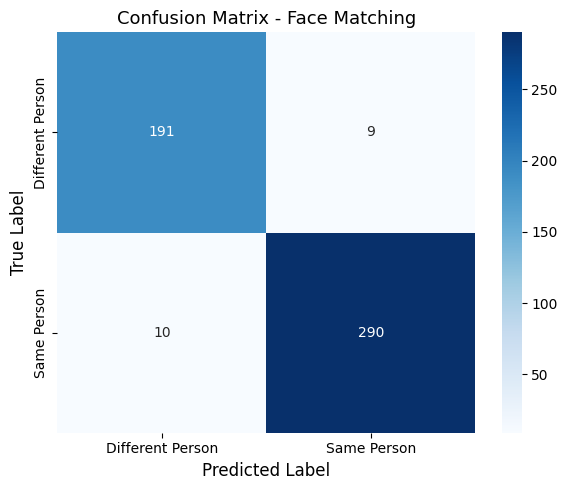

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tính confusion matrix
cm = confusion_matrix(true_labels_arr, final_predictions)

# Vẽ confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Different Person', 'Same Person'],
            yticklabels=['Different Person', 'Same Person'])

plt.title('Confusion Matrix - Face Matching', fontsize=13)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()